# Projeto da Disciplina Algoritmos Não-Supervisionados para Clusterização

- **Nome:** Laíssa Medeiros
- **Data:** 20/11/2022
- **Professor:** Luiz Frias

## Contexto
A HELP International é uma ONG humanitária internacional que está empenhada em combater a pobreza e fornecer ajuda e ​​serviços básicos à população de países subdesenvolvidos, durante o período de desastres e calamidades naturais.
A ONG já conseguiu arrecadar cerca de US$ 10 milhões e agora o CEO precisa decidir como usar esse dinheiro de forma estratégica e eficaz. Portanto, você precisa sugerir os países nos quais o CEO precisa se concentrar e ajudá-lo a tomar a melhor decisão.

## Objetivo
Utilizar os algoritmos de KMeans e Clusterização Hierárquica para agrupar os países utilizando os fatores socioeconômicos e de saúde que determinam o desenvolvimento geral dos países. Interpretar os resultados e identificar as semelhanças e diferenças entre os dois modelos.

## Dataset
Foi utilizado o dataset [Unsupervised Learning on Country Data](https://www.kaggle.com/datasets/rohan0301/unsupervised-learning-on-country-data?select=data-dictionary.csv) do Kaggle, no qual cada linha do dataset representa um país e existem 9 features que representam indicadores socioeconômicos e de saúde que determinam o desenvolvimento geral de cada país.

- **country:** nome do país
- **child_mort:** morte de crianças menores de 5 anos por 1000 nascidos vivos
- **exports:** exportações de bens e serviços per capita. Dado como % da idade do PIB per capita
- **health:** gasto total com saúde per capita. Dado como % de idade do PIB per capita
- **imports:** importações de bens e serviços per capita. Dado como % de idade do PIB per capita
- **Income:** renda líquida por pessoa
- **Inflation:**  medida da taxa de crescimento anual do PIB total
- **life_expec:** número médio de anos que um recém-nascido viveria se os padrões de mortalidade atuais permanecessem os mesmos
- **total_fer:** número de filhos que nasceriam de cada mulher se as taxas atuais de fertilidade por idade permanecessem as mesmas
- **gdpp:** o PIB per capita. Calculado como o PIB total dividido pela população total

# 0. Imports

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from IPython.display       import Image
from IPython.core.display  import HTML
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering

import scipy.cluster.hierarchy as sch


c:\Users\lalaz\Anaconda3\envs\infnet-projeto5\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 0.1. Helper Functions

In [3]:
def jupyter_settings():
    %matplotlib inline
    
    plt.style.use( 'dark_background' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
def distribution( data ):
    
    cols = ['child_mort', 'exports', 'health', 'imports', 'income',
       'inflation', 'life_expec', 'total_fer', 'gdpp']
    
    df = data[cols].copy()

    # tendencia central - media, mediana
    t1 = pd.DataFrame( df.mean() ).T
    t2 = pd.DataFrame( df.median() ).T

    # dispersion - std, min, max, range, skew, kurtosis
    d1 = pd.DataFrame( df.std() ).T
    d2 = pd.DataFrame( df.min() ).T    
    d3 = pd.DataFrame( df.max() ).T
    d4 = pd.DataFrame( df.apply( lambda x: x.max() - x.min() ) ).T
    d5 = pd.DataFrame( df.skew() ).T
    d6 = pd.DataFrame( df.kurtosis() ).T

    # concat
    m1 = pd.DataFrame()
    m1 = pd.concat( [d2, d3, d4, t1, t2, d1, d5, d6] ).T.reset_index()
    m1.columns = ['attributes', 'min', 'max', 'range', 'media', 'mediana', 'std', 'skew', 'kurtosis']
    display(m1)
    
 
def plot_inertia(df, kmin=1, kmax=10, figsize=(8, 4)):

    _range = range(kmin, kmax)
    inertias = []
    for k in _range:
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(df)
        inertias.append(kmeans.inertia_)

    plt.rcParams['figure.figsize'] = (20, 5)
    plt.plot(_range, inertias, 'yx-')
    plt.xlabel('k')
    plt.ylabel('Inertia')
    plt.show()
     
    
def plot_cluster_points(df, labels, title='', ax=None):
    
    pca = PCA(2) 
    pca_data = pd.DataFrame( pca.fit_transform( df ), columns=['PC1','PC2'] ) 
    pca_data['cluster'] = pd.Categorical( labels )
    sns.scatterplot(x="PC1", y="PC2", hue="cluster", data=pca_data, palette='deep', ax=ax).set(title=title)
    

## 0.2. Loading Data

In [4]:
df_raw = pd.read_csv( '../dataset/country-data.csv', low_memory=True )
df_raw.shape

(167, 10)

In [5]:
df_raw.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


# 1. Data Description

In [6]:
df1 = df_raw.copy()

## 1.1 Data Dimensions

In [7]:
print( 'Number of rows: {}'.format( df1.shape[0] ) )
print( 'Number of columns: {}'.format( df1.shape[1] ) )

Number of rows: 167
Number of columns: 10


Existe um total de 167 países no dataset.

## 1.2. NA Check

In [8]:
df1.isna().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

## 1.3. Data Type

In [9]:
df1.dtypes

country        object
child_mort    float64
exports       float64
health        float64
imports       float64
income          int64
inflation     float64
life_expec    float64
total_fer     float64
gdpp            int64
dtype: object

In [10]:
# income
df1['income'] = df1['income'].astype( np.float64 )

# gdpp
df1['gdpp'] = df1['gdpp'].astype( np.float64 )

In [11]:
df1.dtypes

country        object
child_mort    float64
exports       float64
health        float64
imports       float64
income        float64
inflation     float64
life_expec    float64
total_fer     float64
gdpp          float64
dtype: object

## 1.4. Check Balanced Data

In [12]:
df1['country'].value_counts( normalize=True )

Afghanistan    0.005988
Morocco        0.005988
Myanmar        0.005988
Namibia        0.005988
Nepal          0.005988
                 ...   
Georgia        0.005988
Germany        0.005988
Ghana          0.005988
Greece         0.005988
Zambia         0.005988
Name: country, Length: 167, dtype: float64

## 1.5 Descriptive Statistics

In [13]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

In [14]:
distribution(num_attributes)

,attributes,min,max,range,media,mediana,std,skew,kurtosis
0,child_mort,2.6000,208.00,205.4000,38.270060,19.30,40.328931,1.450774,1.766882
1,exports,0.1090,200.00,199.8910,41.108976,35.00,27.412010,2.445824,10.138666
2,health,1.8100,17.90,16.0900,6.815689,6.32,2.746837,0.705746,0.694196
3,imports,0.0659,174.00,173.9341,46.890215,43.30,24.209589,1.905276,6.755854
4,income,609.0000,125000.00,124391.0000,17144.688623,9960.00,19278.067698,2.231480,7.028657
5,inflation,-4.2100,104.00,108.2100,7.781832,5.39,10.570704,5.154049,41.742502
6,life_expec,32.1000,82.80,50.7000,70.555689,73.10,8.893172,-0.970996,1.151591
7,total_fer,1.1500,7.49,6.3400,2.947964,2.41,1.513848,0.967092,-0.186779
8,gdpp,231.0000,105000.00,104769.0000,12964.155689,4660.00,18328.704809,2.218051,5.527891


- **Min**: menor valor do conjunto de dados
- **Max**: maior valor do conjunto de dados
- **Range**: diferença entre o maior e o menor valor do conjutno de dados
- **Média**: resume o conjunto de dados em um ponto central
- **Mediana**: representa o número do meio de uma lista ordenada
- **Desvio Padrao**: estimativa de dispersão ou variabilidade. Mede a dispersão dos valores do conjunto de dados em torno da média
- **Skewness**: medida de assimetria da distruição de dados, em relação a uma distribuição normal
  - Mediana > Média: Deslocamento para a esquerda = Skewness Negativa 
  - Mediana < Média: Deslocamento para a direita = Skewness Positiva 
- **Kurtosis**: evidencia as caudas longas, probabilidade de acontecer valor extremos, seja mínimos ou máximos



# 2. Exploratory Data Analysis (EDA)

In [15]:
df2 = df1.copy()

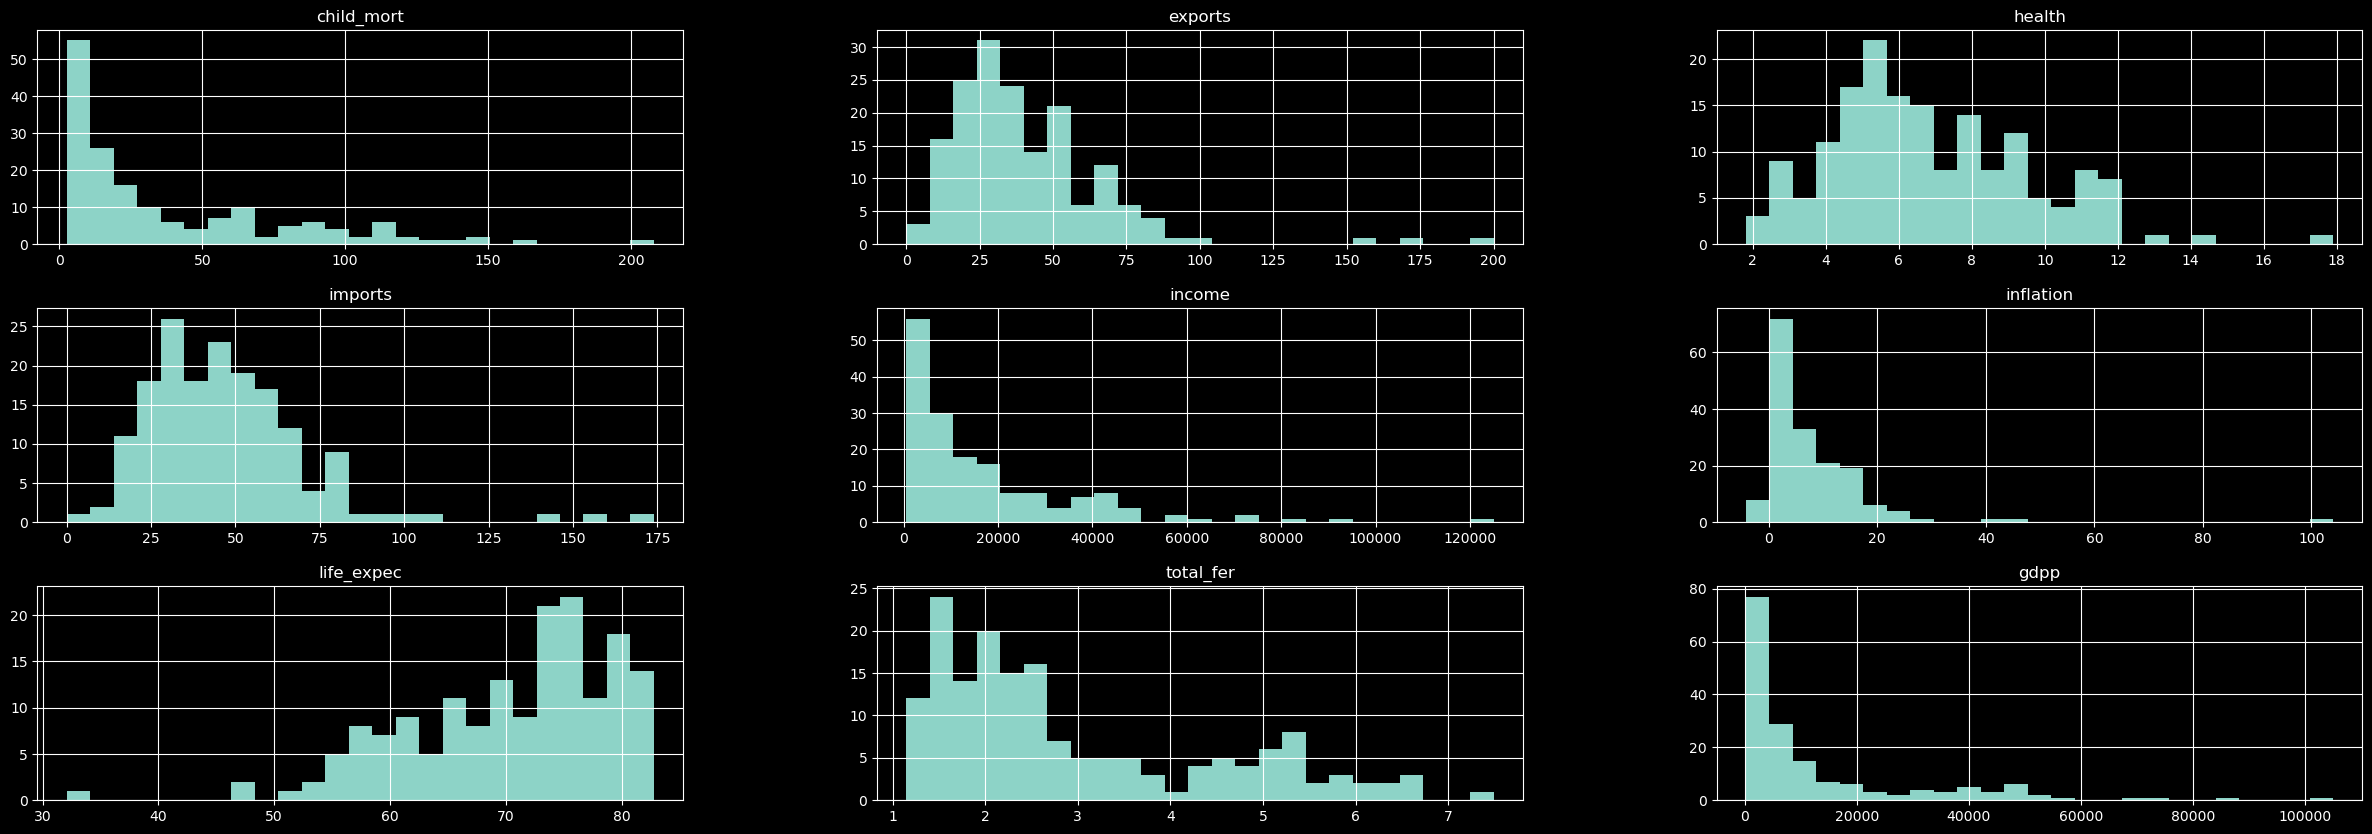

In [16]:
# Distribuições

plt.rcParams['figure.figsize'] = (30, 10)
num_attributes.hist(bins=25);

#Nenhuma feature possui distribuição normal

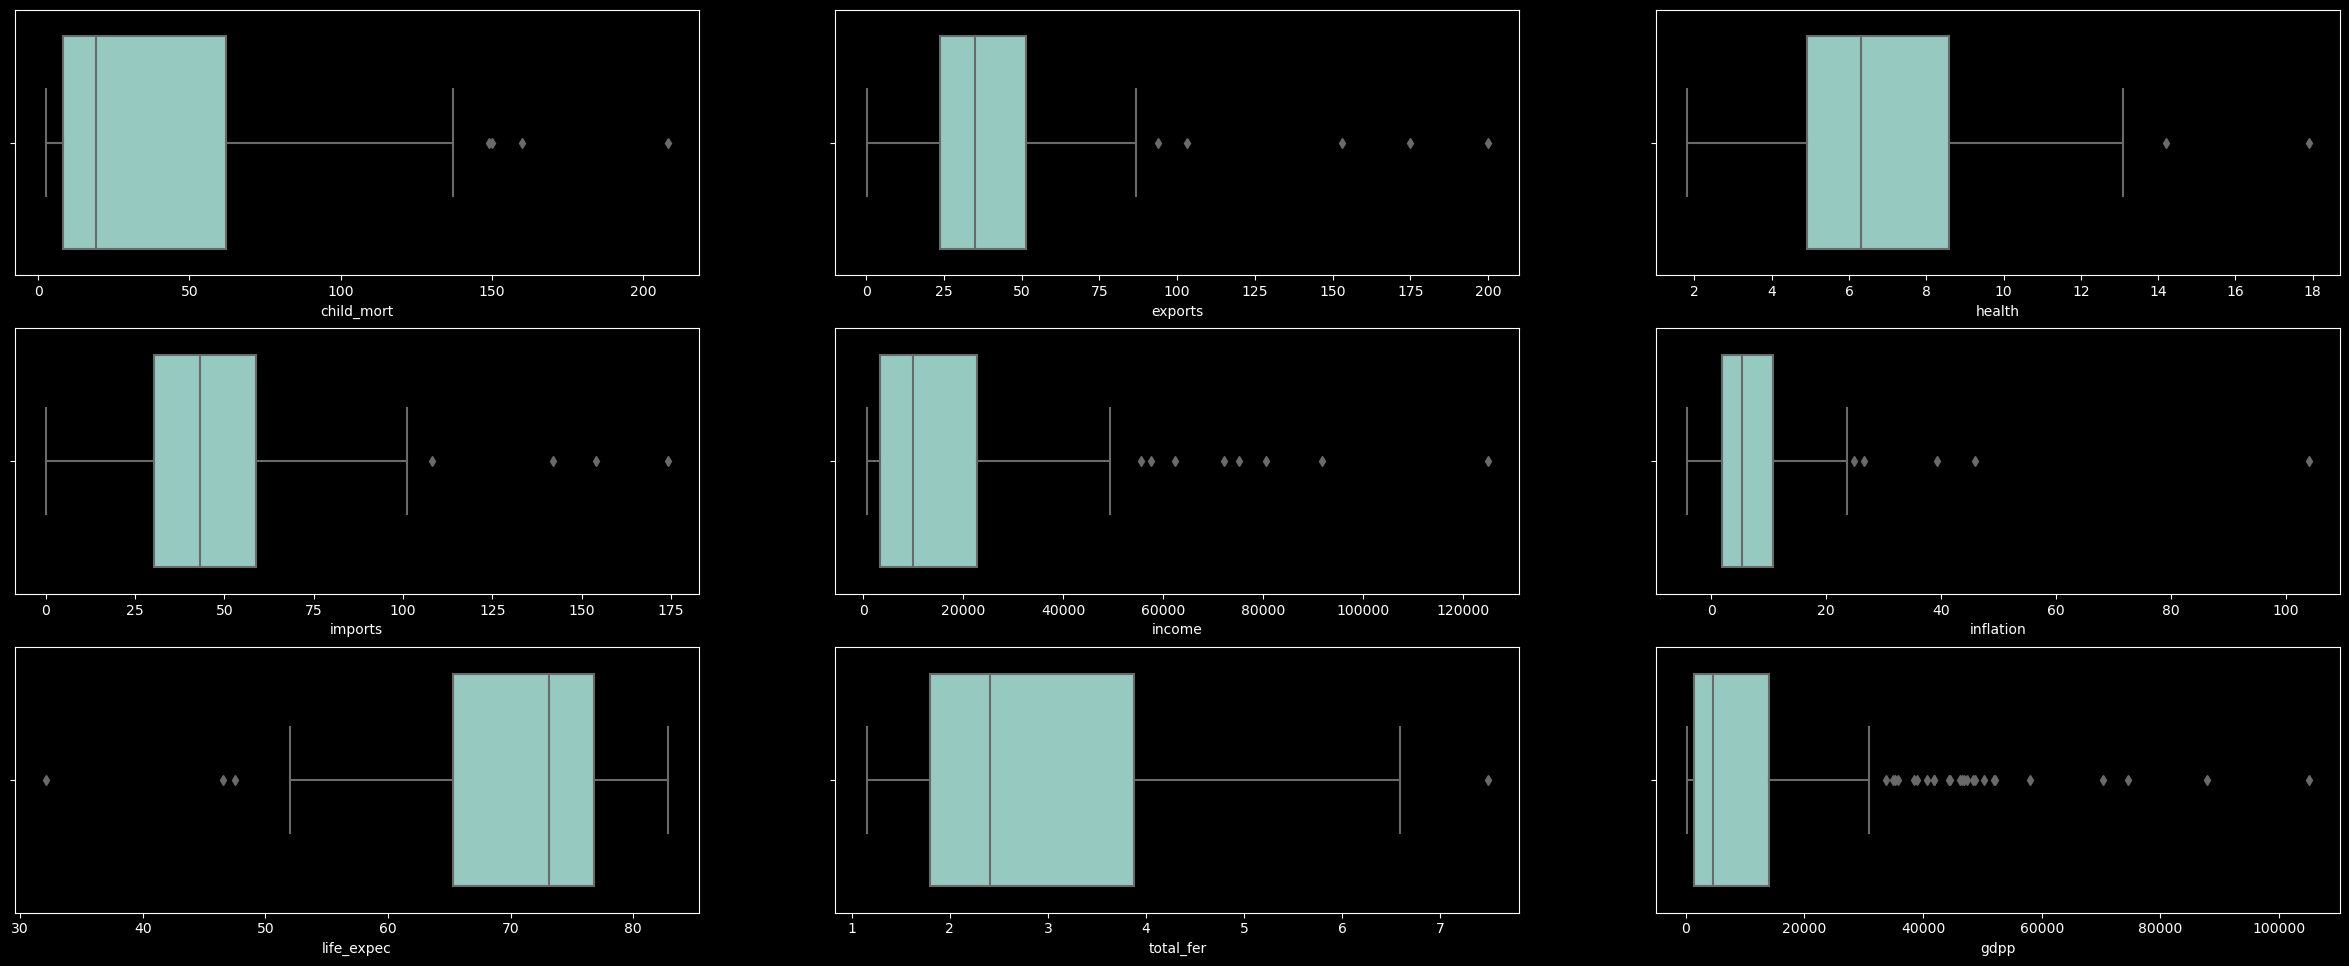

In [17]:
# Outliers

n = 1
plt.figure(figsize=(30,20))
for col in num_attributes.columns: 
    plt.subplot(5, 3, n)
    n = n + 1
    sns.boxplot( x=col, data=df2 )
    
    
# Todas as features apresentam outliers

<AxesSubplot:>

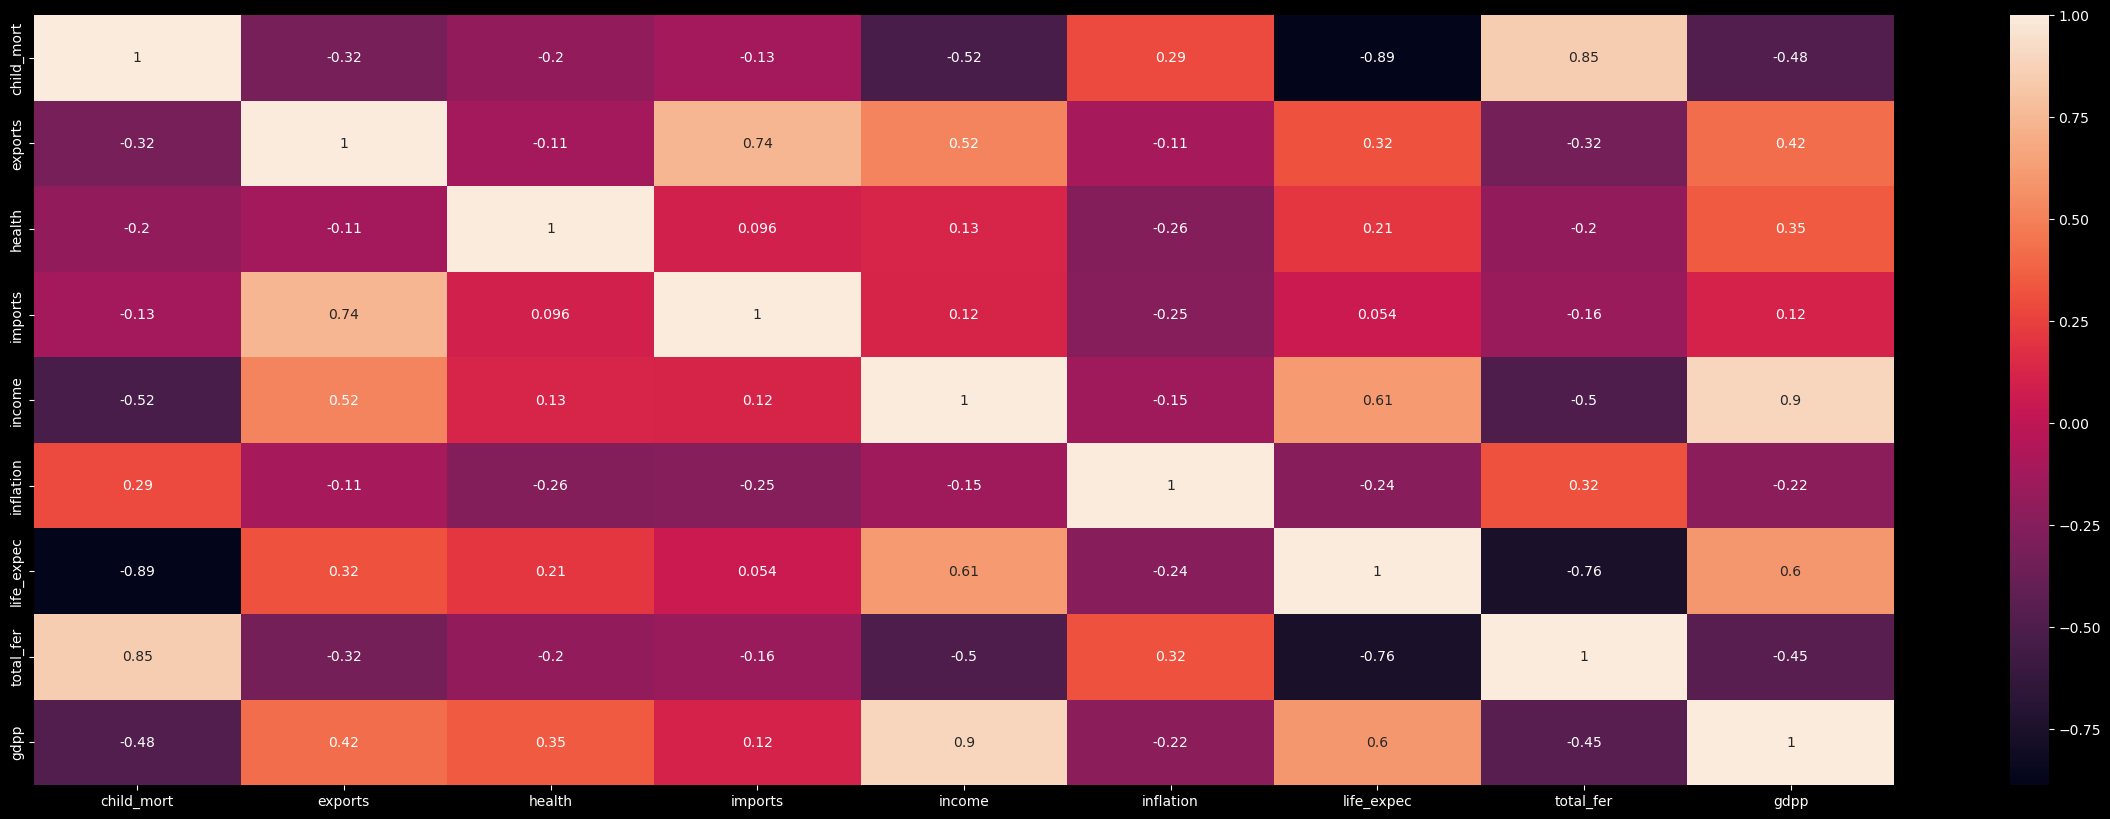

In [18]:
plt.rcParams['figure.figsize'] = (30, 10)

correlation = num_attributes.corr( method='pearson')
sns.heatmap( correlation, annot=True )


# Observamos uma correlação positiva entre as features gdpp e income
# Observamos uma correlação negativa entre as features child_mort e life_expect; total_fer e life_expect

c:\Users\lalaz\Anaconda3\envs\infnet-projeto5\lib\site-packages\seaborn\axisgrid.py:181: UserWarning: The handle <matplotlib.patches.Patch object at 0x000002B153A6BEB0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  figlegend = self._figure.legend(handles, labels, **kwargs)


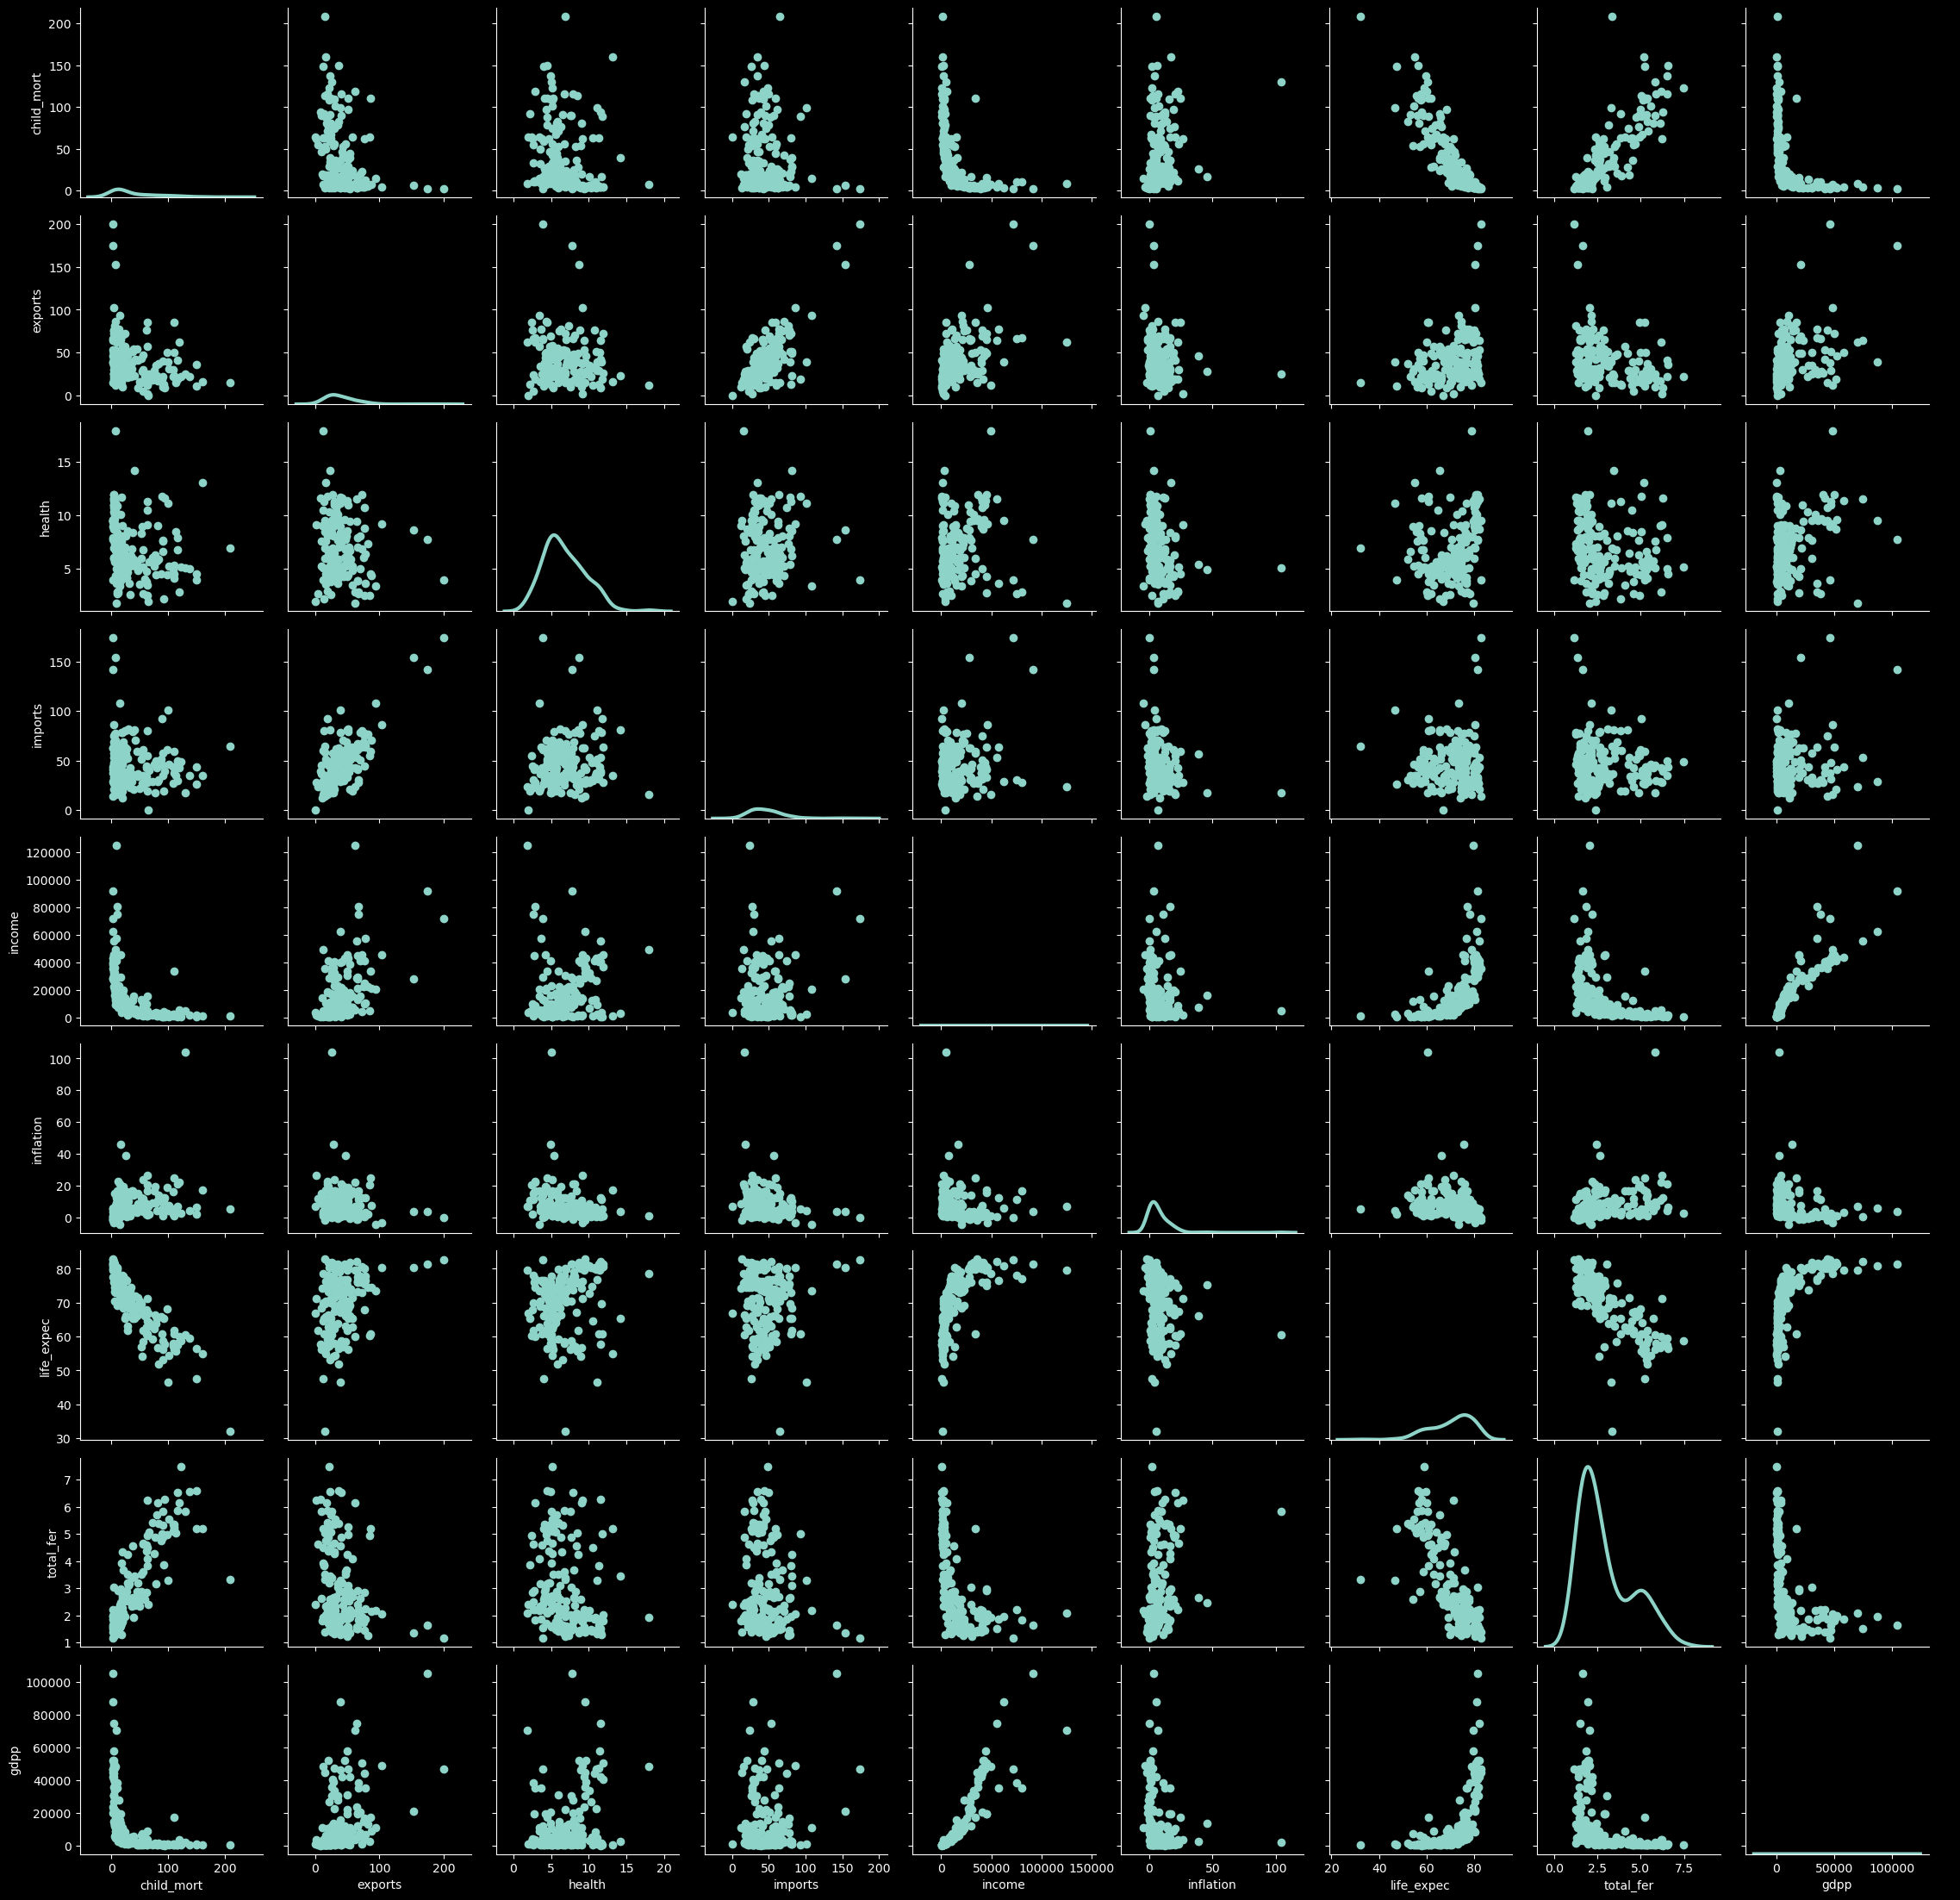

In [19]:
g = sns.PairGrid( num_attributes, vars = num_attributes.columns )
g.map_diag( sns.kdeplot, lw=3 )
g.map_offdiag( plt.scatter )
g.add_legend()

# 3. Data Preparation

In [20]:
df3 = df2.copy()

Regra para normalização dos dados:
1. **Standard Scaler**: features que possuem distribuiçåo normal e não possuem outlier
2. **Robust Scaler**: features que possuem distribuiçåo normal e possuem outlier
3. **Min Max Scaler**: features que não possuem distribuição normal

In [21]:
mms = MinMaxScaler()

# child_mort
df3['child_mort'] = mms.fit_transform( df3[['child_mort']].values )

# exports
df3['exports'] = mms.fit_transform( df3[['exports']].values )

# health
df3['health'] = mms.fit_transform( df3[['health']].values )

# imports
df3['imports'] = mms.fit_transform( df3[['imports']].values )

# income
df3['income'] = mms.fit_transform( df3[['income']].values )

# inflation
df3['inflation'] = mms.fit_transform( df3[['inflation']].values )

# life_expec
df3['life_expec'] = mms.fit_transform( df3[['life_expec']].values )

# total_fer
df3['total_fer'] = mms.fit_transform( df3[['total_fer']].values )

# gdpp
df3['gdpp'] = mms.fit_transform( df3[['gdpp']].values )


In [22]:
df3.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,0.426485,0.049482,0.358608,0.257765,0.008047,0.126144,0.475345,0.736593,0.003073
1,Albania,0.068160,0.139531,0.294593,0.279037,0.074933,0.080399,0.871795,0.078864,0.036833
2,Algeria,0.120253,0.191559,0.146675,0.180149,0.098809,0.187691,0.875740,0.274448,0.040365
3,Angola,0.566699,0.311125,0.064636,0.246266,0.042535,0.245911,0.552268,0.790221,0.031488
4,Antigua and Barbuda,0.037488,0.227079,0.262275,0.338255,0.148652,0.052213,0.881657,0.154574,0.114242


# 5. Machine Learning Model - Clustering

In [23]:
df4 = df3.copy()
df4 = df4.set_index('country')

## 5.1 K-Means

### 5.1.1 Finding the number of clusters

c:\Users\lalaz\Anaconda3\envs\infnet-projeto5\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


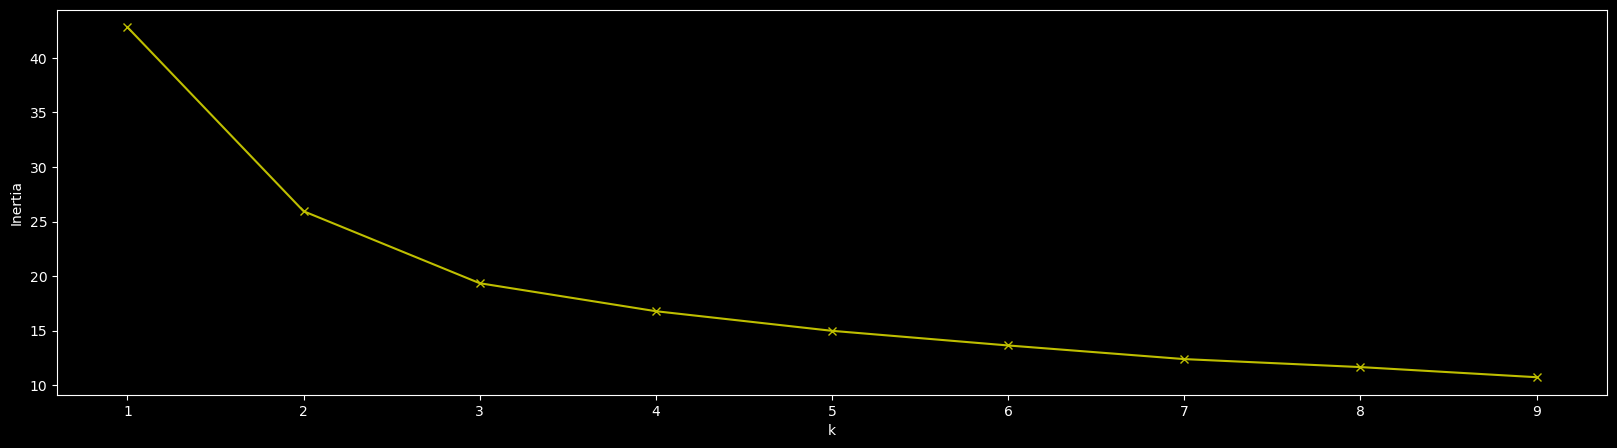

In [24]:
plot_inertia(df4)

### 5.1.2 Clustering

In [25]:
model_kmeans = KMeans( n_clusters = 3, random_state = 1234 )
k_fit = model_kmeans.fit( df4 )

In [26]:
# centróide de cada cluster
k_fit.cluster_centers_

array([[0.09652182, 0.20147696, 0.27380866, 0.26944838, 0.09777085,
        0.10922302, 0.79847255, 0.18032426, 0.06193426],
       [0.44150332, 0.14597042, 0.28144675, 0.24855348, 0.02337632,
        0.15069832, 0.5383329 , 0.62148539, 0.01398231],
       [0.01118375, 0.29177116, 0.44172956, 0.29575955, 0.36332096,
        0.0623325 , 0.94961961, 0.0932402 , 0.40934   ]])

In [27]:
# cluster encontrado para cada ponto do dataset
clusters = k_fit.labels_
clusters

array([1, 0, 0, 1, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0,
       0, 2, 0, 1, 1, 0, 1, 2, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 2, 2,
       2, 0, 0, 0, 0, 1, 1, 0, 0, 2, 2, 1, 1, 0, 2, 1, 2, 0, 0, 1, 1, 0,
       1, 0, 2, 0, 0, 0, 1, 2, 2, 2, 0, 2, 0, 0, 1, 1, 2, 0, 1, 0, 0, 1,
       1, 0, 0, 2, 0, 1, 1, 0, 0, 1, 2, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       2, 2, 1, 1, 2, 0, 1, 0, 0, 0, 0, 0, 2, 2, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 2, 2, 2, 1, 0, 2, 2, 0, 0, 1, 0, 2, 2, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 2, 2, 2, 0, 0, 0, 0, 0, 1, 1])

### 5.1.3 Cluster Analysis

In [92]:
df_result = df2.copy()
df_result['kmeans_cluster'] = clusters
df_result.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,kmeans_cluster
0,Afghanistan,90.2,10.0,7.58,44.9,1610.0,9.44,56.2,5.82,553.0,1
1,Albania,16.6,28.0,6.55,48.6,9930.0,4.49,76.3,1.65,4090.0,0
2,Algeria,27.3,38.4,4.17,31.4,12900.0,16.10,76.5,2.89,4460.0,0
3,Angola,119.0,62.3,2.85,42.9,5900.0,22.40,60.1,6.16,3530.0,1
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100.0,1.44,76.8,2.13,12200.0,0


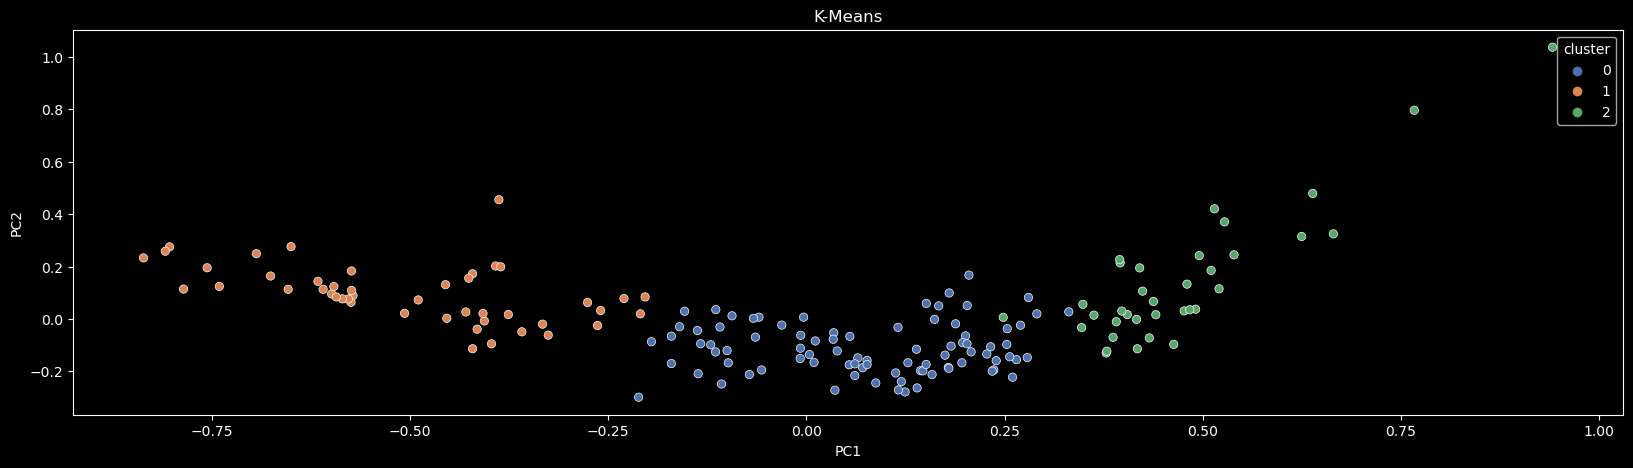

In [93]:
# visualização dos clusters
plot_cluster_points( df4, model_kmeans.labels_, title='K-Means' )

In [94]:
# distribuição dos clusters
i=1
for i in range(0,3):
   print("Distribuição das features do Cluster " + str(i))
   distribution( df_result.loc[ df_result['kmeans_cluster'] == i] )
   i = i + 1 

Distribuição das features do Cluster 0


,attributes,min,max,range,media,mediana,std,skew,kurtosis
0,child_mort,4.5000,64.40,59.9000,22.425581,18.350,14.459934,1.140820,0.631029
1,exports,0.1090,93.80,93.6910,40.382430,37.300,19.089329,0.615331,0.045611
2,health,1.9700,14.20,12.2300,6.215581,5.930,2.163140,0.884694,1.614352
3,imports,0.0659,108.00,107.9341,46.932162,48.650,19.647602,0.227651,0.018156
4,income,1990.0000,45400.00,43410.0000,12770.813953,10700.000,8578.103618,1.714854,4.319855
5,inflation,-4.2100,45.90,50.1100,7.609023,5.935,7.758666,2.381725,8.601303
6,life_expec,54.3000,80.40,26.1000,72.582558,73.600,4.568156,-1.330548,2.983407
7,total_fer,1.2500,4.34,3.0900,2.293256,2.235,0.659719,0.595076,0.140681
8,gdpp,592.0000,28000.00,27408.0000,6719.790698,5050.000,5160.729689,1.475470,2.836444


Distribuição das features do Cluster 1


,attributes,min,max,range,media,mediana,std,skew,kurtosis
0,child_mort,28.100,208.00,179.900,93.284783,90.250,34.079410,0.903050,1.717107
1,exports,2.200,85.80,83.600,29.287174,23.800,18.479530,1.348760,2.065715
2,health,2.200,13.10,10.900,6.338478,5.480,2.668183,0.807132,0.023138
3,imports,17.200,101.00,83.800,43.297826,41.500,18.636362,1.233078,1.749606
4,income,609.000,33700.00,33091.000,3516.804348,1835.000,5391.402727,4.417010,22.587170
5,inflation,0.885,104.00,103.115,12.097065,8.995,15.670791,4.658852,26.935162
6,life_expec,32.100,71.10,39.000,59.393478,60.250,6.473859,-1.745335,6.188353
7,total_fer,3.150,7.49,4.340,5.090217,5.085,0.940327,0.046133,0.067501
8,gdpp,231.000,17100.00,16869.000,1695.913043,833.000,2795.655748,4.299929,21.343495


Distribuição das features do Cluster 2


,attributes,min,max,range,media,mediana,std,skew,kurtosis
0,child_mort,2.60,10.80,8.20,4.897143,4.20,2.130795,1.493341,1.603529
1,exports,12.40,200.00,187.60,58.431429,50.20,42.501749,1.972990,4.132310
2,health,1.81,17.90,16.09,8.917429,9.48,3.154562,-0.262746,1.618085
3,imports,13.60,174.00,160.40,51.508571,37.40,37.381754,2.061318,4.137344
4,income,25200.00,125000.00,99800.00,45802.857143,40400.00,21141.490928,2.084194,5.056423
5,inflation,-3.22,16.70,19.92,2.535000,1.16,4.053256,1.941198,4.319959
6,life_expec,75.50,82.80,7.30,80.245714,80.40,1.696596,-1.018158,1.021155
7,total_fer,1.15,3.03,1.88,1.741143,1.79,0.371814,1.105588,2.674664
8,gdpp,16600.00,105000.00,88400.00,43117.142857,41800.00,18891.773587,1.401525,2.765667


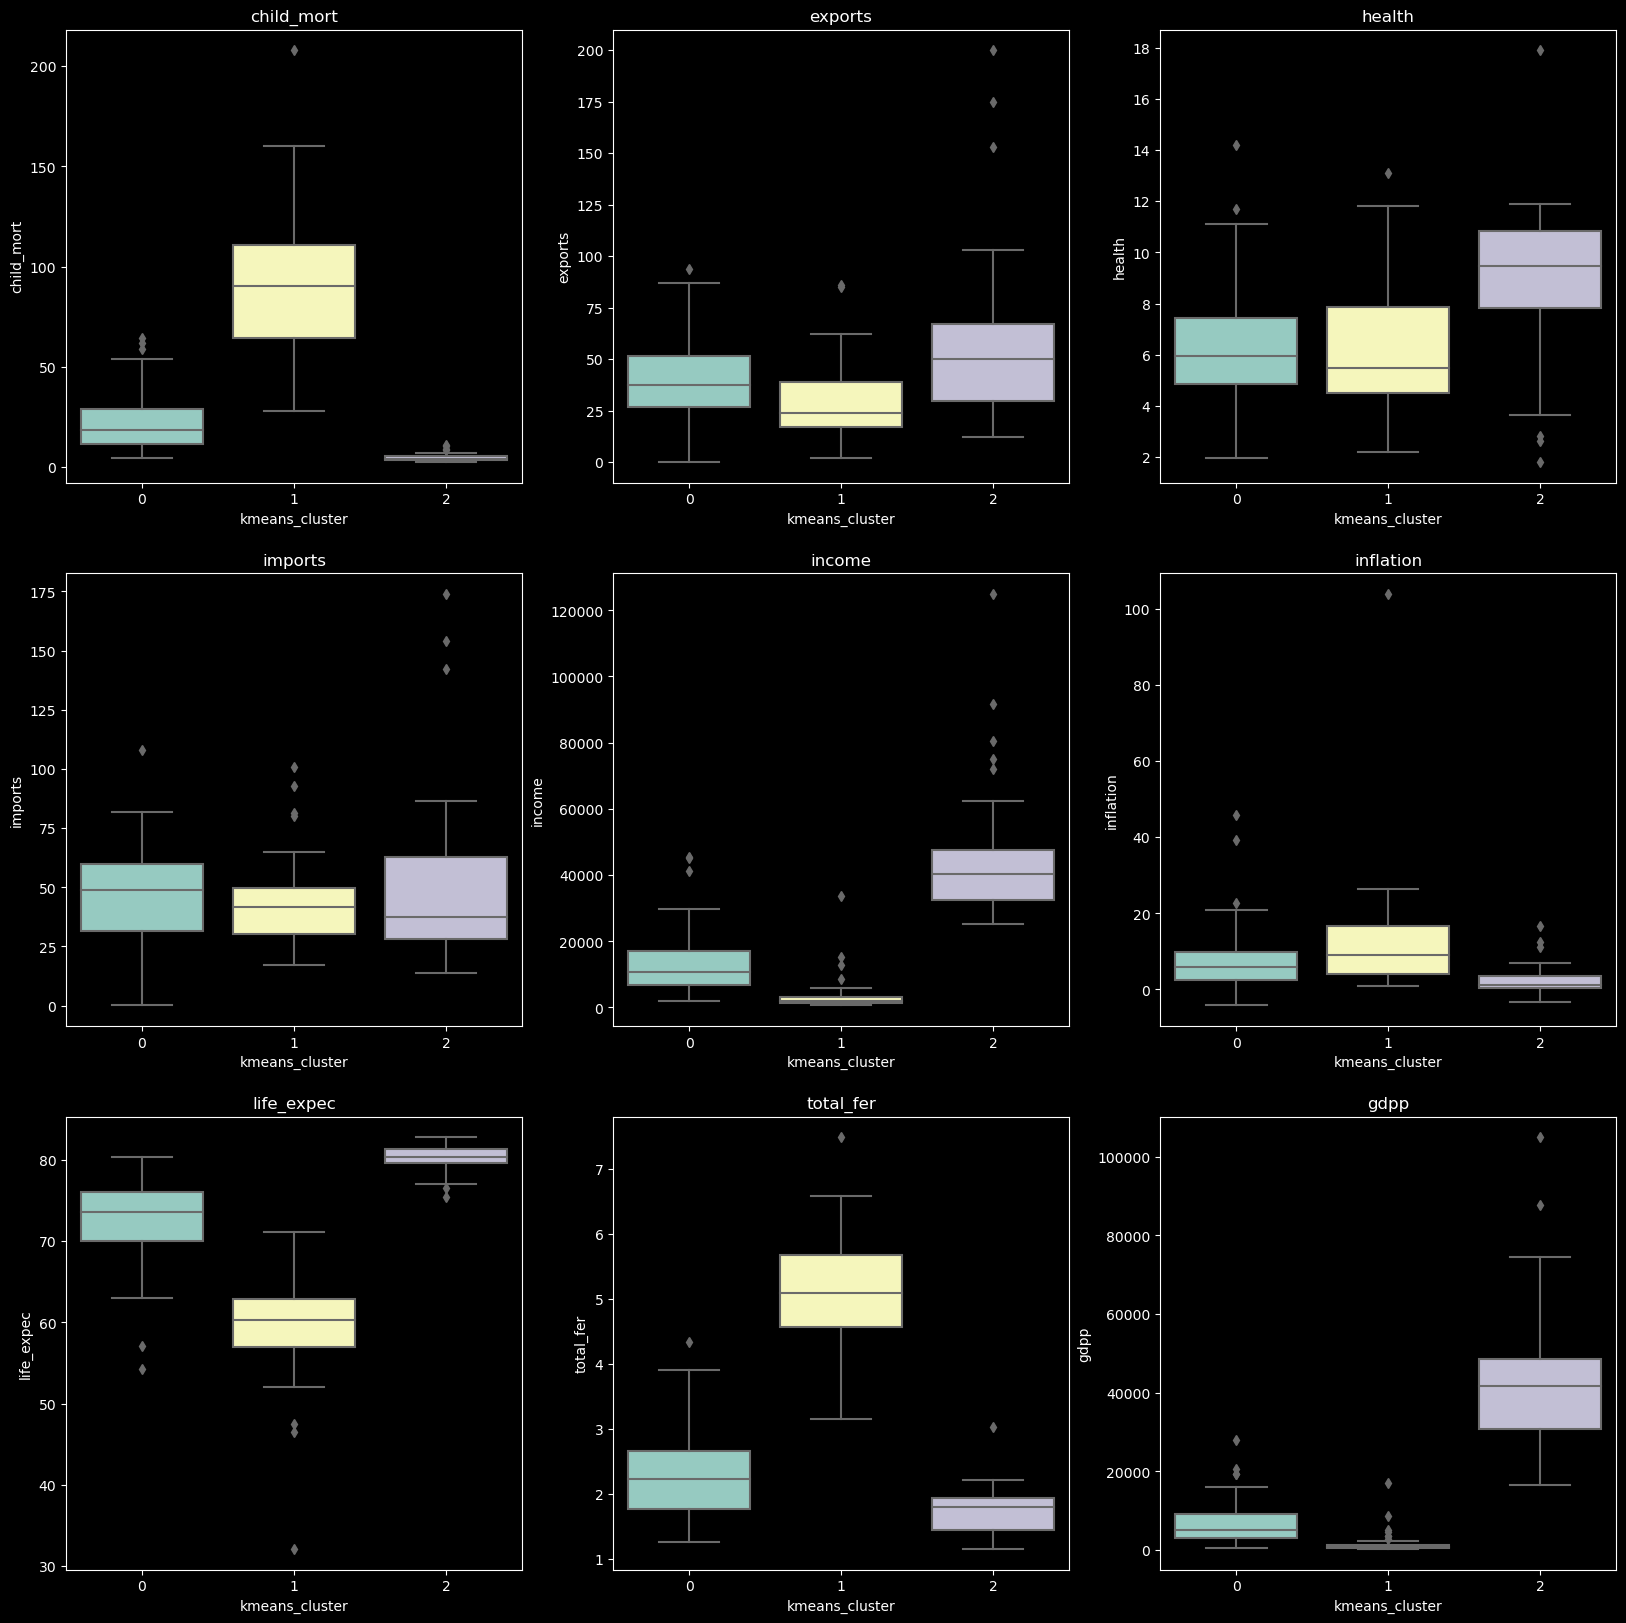

In [95]:
plt.figure(figsize=(20,20))

cols = ['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']

for i in range(len(cols)):
    plt.subplot( 3, 3, i + 1)
    sns.boxplot( x=df_result['kmeans_cluster'], y=df_result[ cols[i] ] )
    plt.title( cols[i])

In [99]:
# o país que melhor representa o seu agrupamento, será o país mais próximo ao centróide de seu cluster

df_aux = df3.copy()
df_aux['kmeans_cluster'] = clusters

cols = ['child_mort', 'exports', 'health', 'imports', 'income', 'inflation','life_expec', 'total_fer', 'gdpp']
i=1
for i in range(0,3):

    df_cluster = df_aux[ df_aux['kmeans_cluster']==i ]
    df_aux2 = df_cluster[cols].copy()

    df_aux2['distance'] = df_aux2.apply(lambda x: np.linalg.norm( x - k_fit.cluster_centers_[0]), axis=1)

    print("País que melhor representa o Cluster " + str(i) + ": " + df_cluster.loc[ df_aux2['distance'].idxmin() , 'country' ])

País que melhor representa o Cluster 0: Suriname
País que melhor representa o Cluster 1: Lao
País que melhor representa o Cluster 2: South Korea


A partir das distribuições das features para cada cluster, pode-se classificar os 3 grupos de países em:
- **Cluster 0**: Emergentes
- **Cluster 1**: Subdesenvolvidos
- **Cluster 2**: Desenvolvidos

In [100]:
df_result['kmeans_class']=""
df_result.loc[ df_result['kmeans_cluster'] == 2, 'kmeans_class'] = 'Desenvolvido'
df_result.loc[ df_result['kmeans_cluster'] == 1, 'kmeans_class'] = 'Subdesenvolvido'
df_result.loc[ df_result['kmeans_cluster'] == 0, 'kmeans_class'] = 'Emergente'

In [101]:
fig = px.choropleth(df_result[['country','kmeans_class']],
                    locationmode = 'country names',
                    locations = 'country',
                    color = df_result['kmeans_class'],
                    color_discrete_map={'Desenvolvido':'blue', 'Emergente':'goldenrod', 'Subdesenvolvido':'red'},
                    title = 'KMeans Clustered Countries'                 
)

fig.update_geos(fitbounds = "locations", 
                visible = False
                )

fig.update_layout(mapbox_style="carto-positron",
                  height=600, 
                  width = 1000,
                  margin={"r":0,"t":0,"l":0,"b":0},
                  title_x=0.02,
                  title_y=0.98,
                  legend_title_text = 'Country',
                  geo=dict(
                        showframe=False,
                        showcoastlines=True,
                        projection_type='equirectangular',
                    ),
                 )

fig.show()



## 5.2 Hierarchical Clustering

### 5.2.1 Dendogram

In [105]:
df5 = df2.copy()
df5 = df5.set_index('country')

Text(0, 0.5, 'Euclidean Distance')

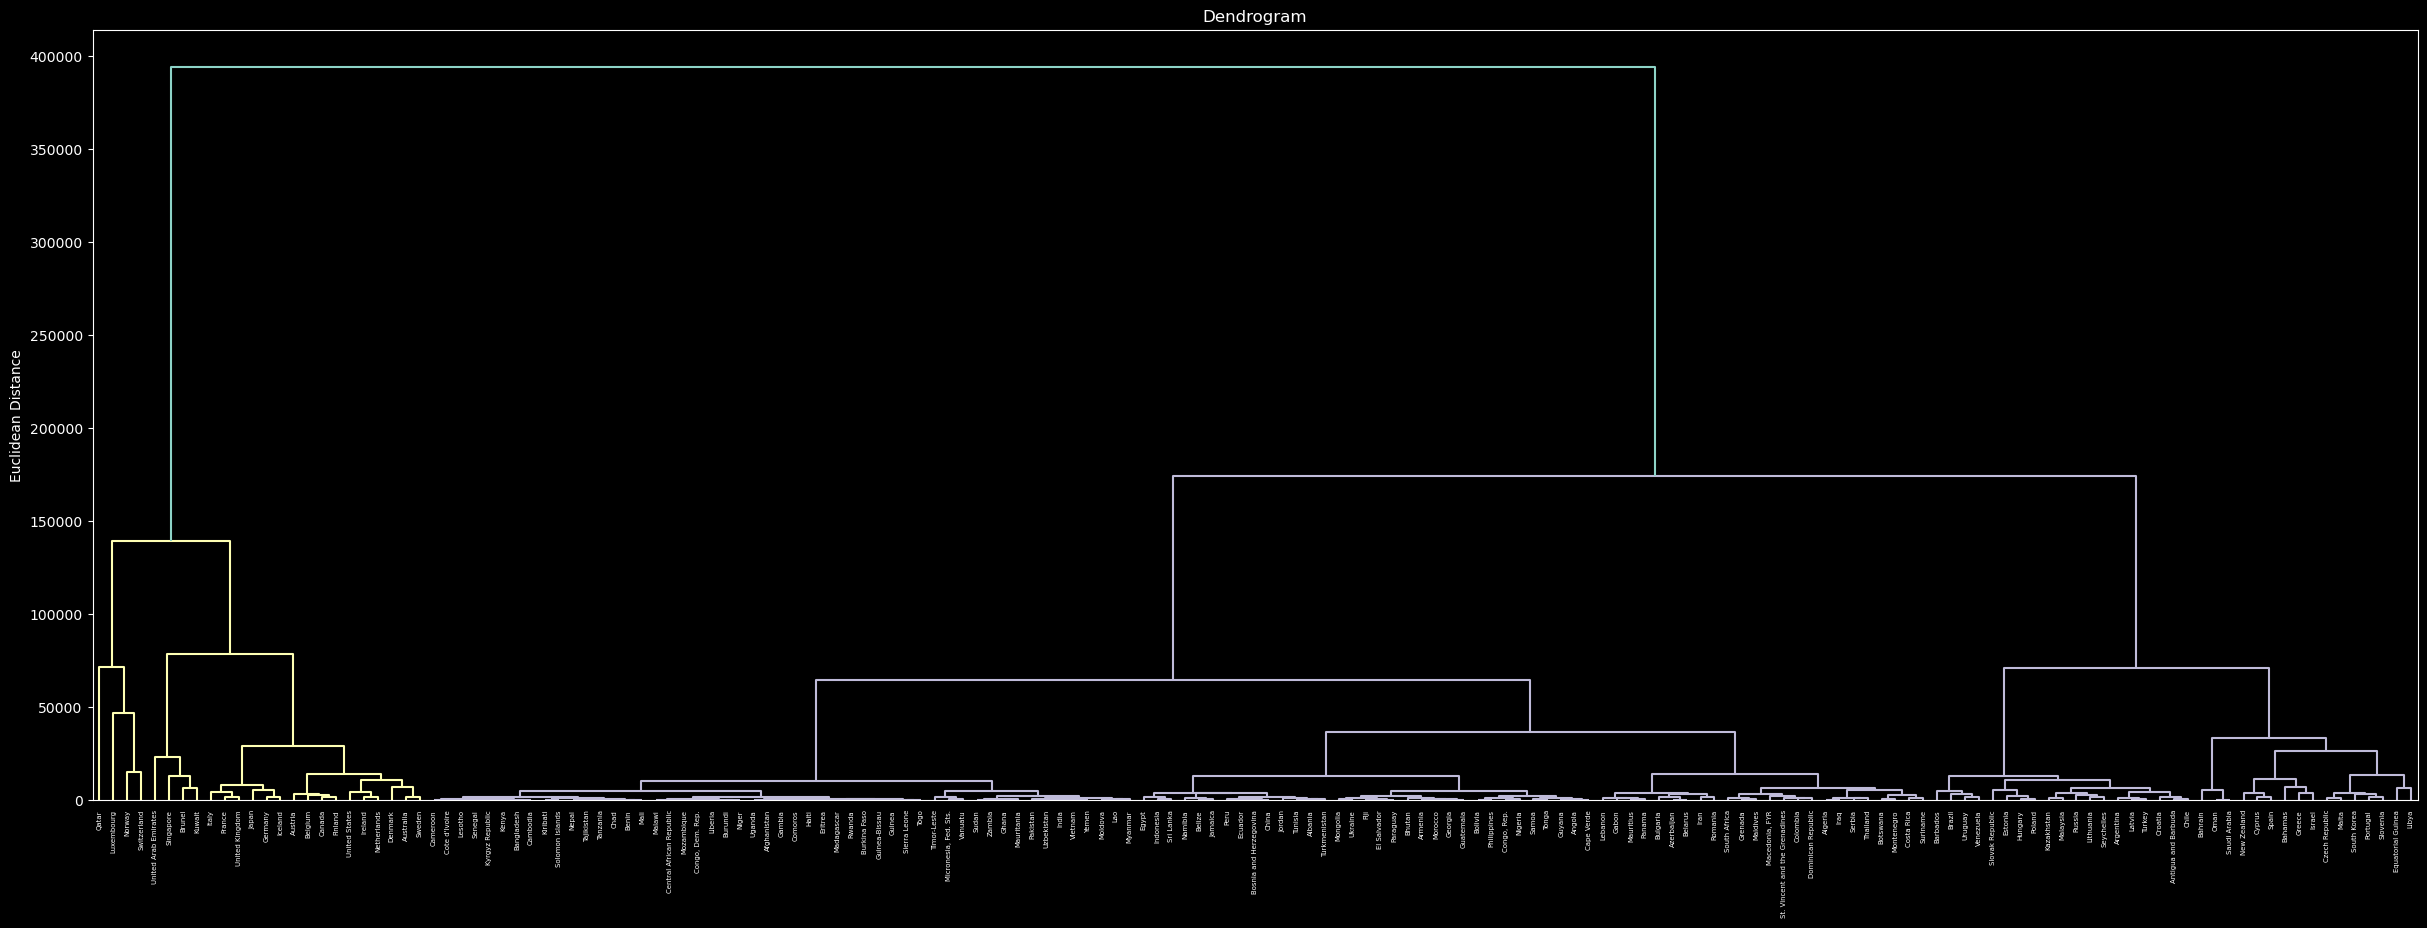

In [106]:
plt.figure(figsize=(30, 10))
plt.grid(False)

dendrogram = sch.dendrogram(sch.linkage(df5, method='ward'), labels=df5.index)

plt.title('Dendrogram')
plt.ylabel('Euclidean Distance')

### 5.2.2 Clustering

In [107]:
model_agg = AgglomerativeClustering(n_clusters=3)
model_agg.fit( df4 )

AgglomerativeClustering(n_clusters=3)

In [108]:
df_result['hier_cluster'] = model_agg.labels_
df_result.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,kmeans_cluster,kmeans_class,hier_cluster
0,Afghanistan,90.2,10.0,7.58,44.9,1610.0,9.44,56.2,5.82,553.0,1,Subdesenvolvido,1
1,Albania,16.6,28.0,6.55,48.6,9930.0,4.49,76.3,1.65,4090.0,0,Emergente,2
2,Algeria,27.3,38.4,4.17,31.4,12900.0,16.10,76.5,2.89,4460.0,0,Emergente,2
3,Angola,119.0,62.3,2.85,42.9,5900.0,22.40,60.1,6.16,3530.0,1,Subdesenvolvido,1
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100.0,1.44,76.8,2.13,12200.0,0,Emergente,2


### 5.2.3 Cluster Analysis

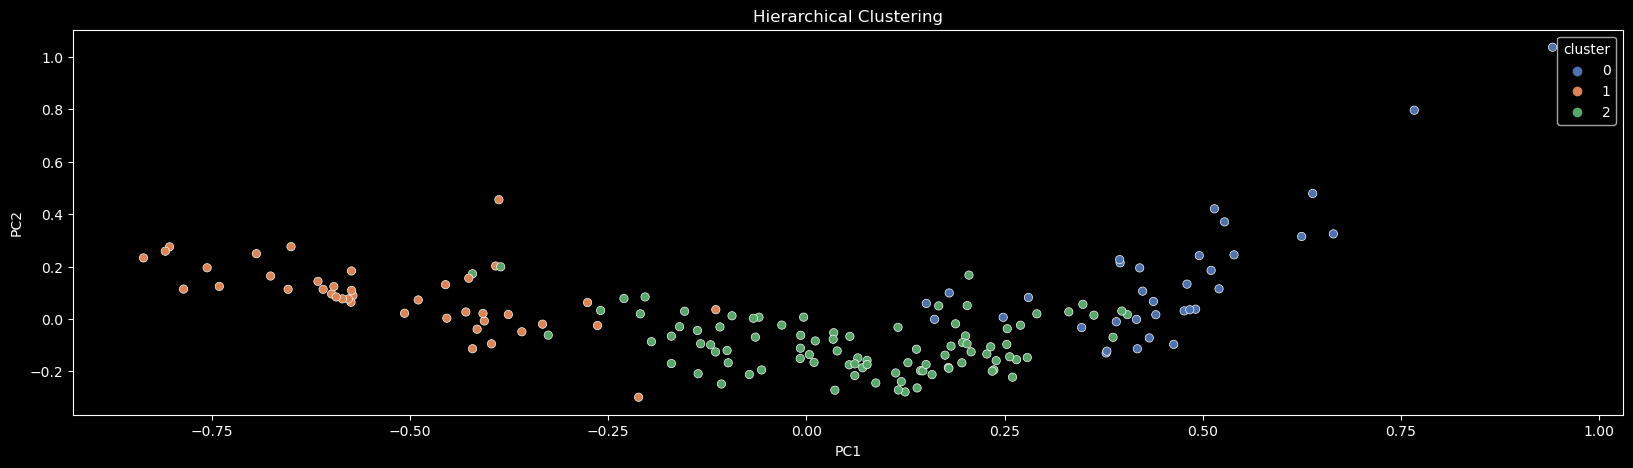

In [109]:
# visualização dos clusters
plot_cluster_points( df4, model_agg.labels_, title='Hierarchical Clustering')

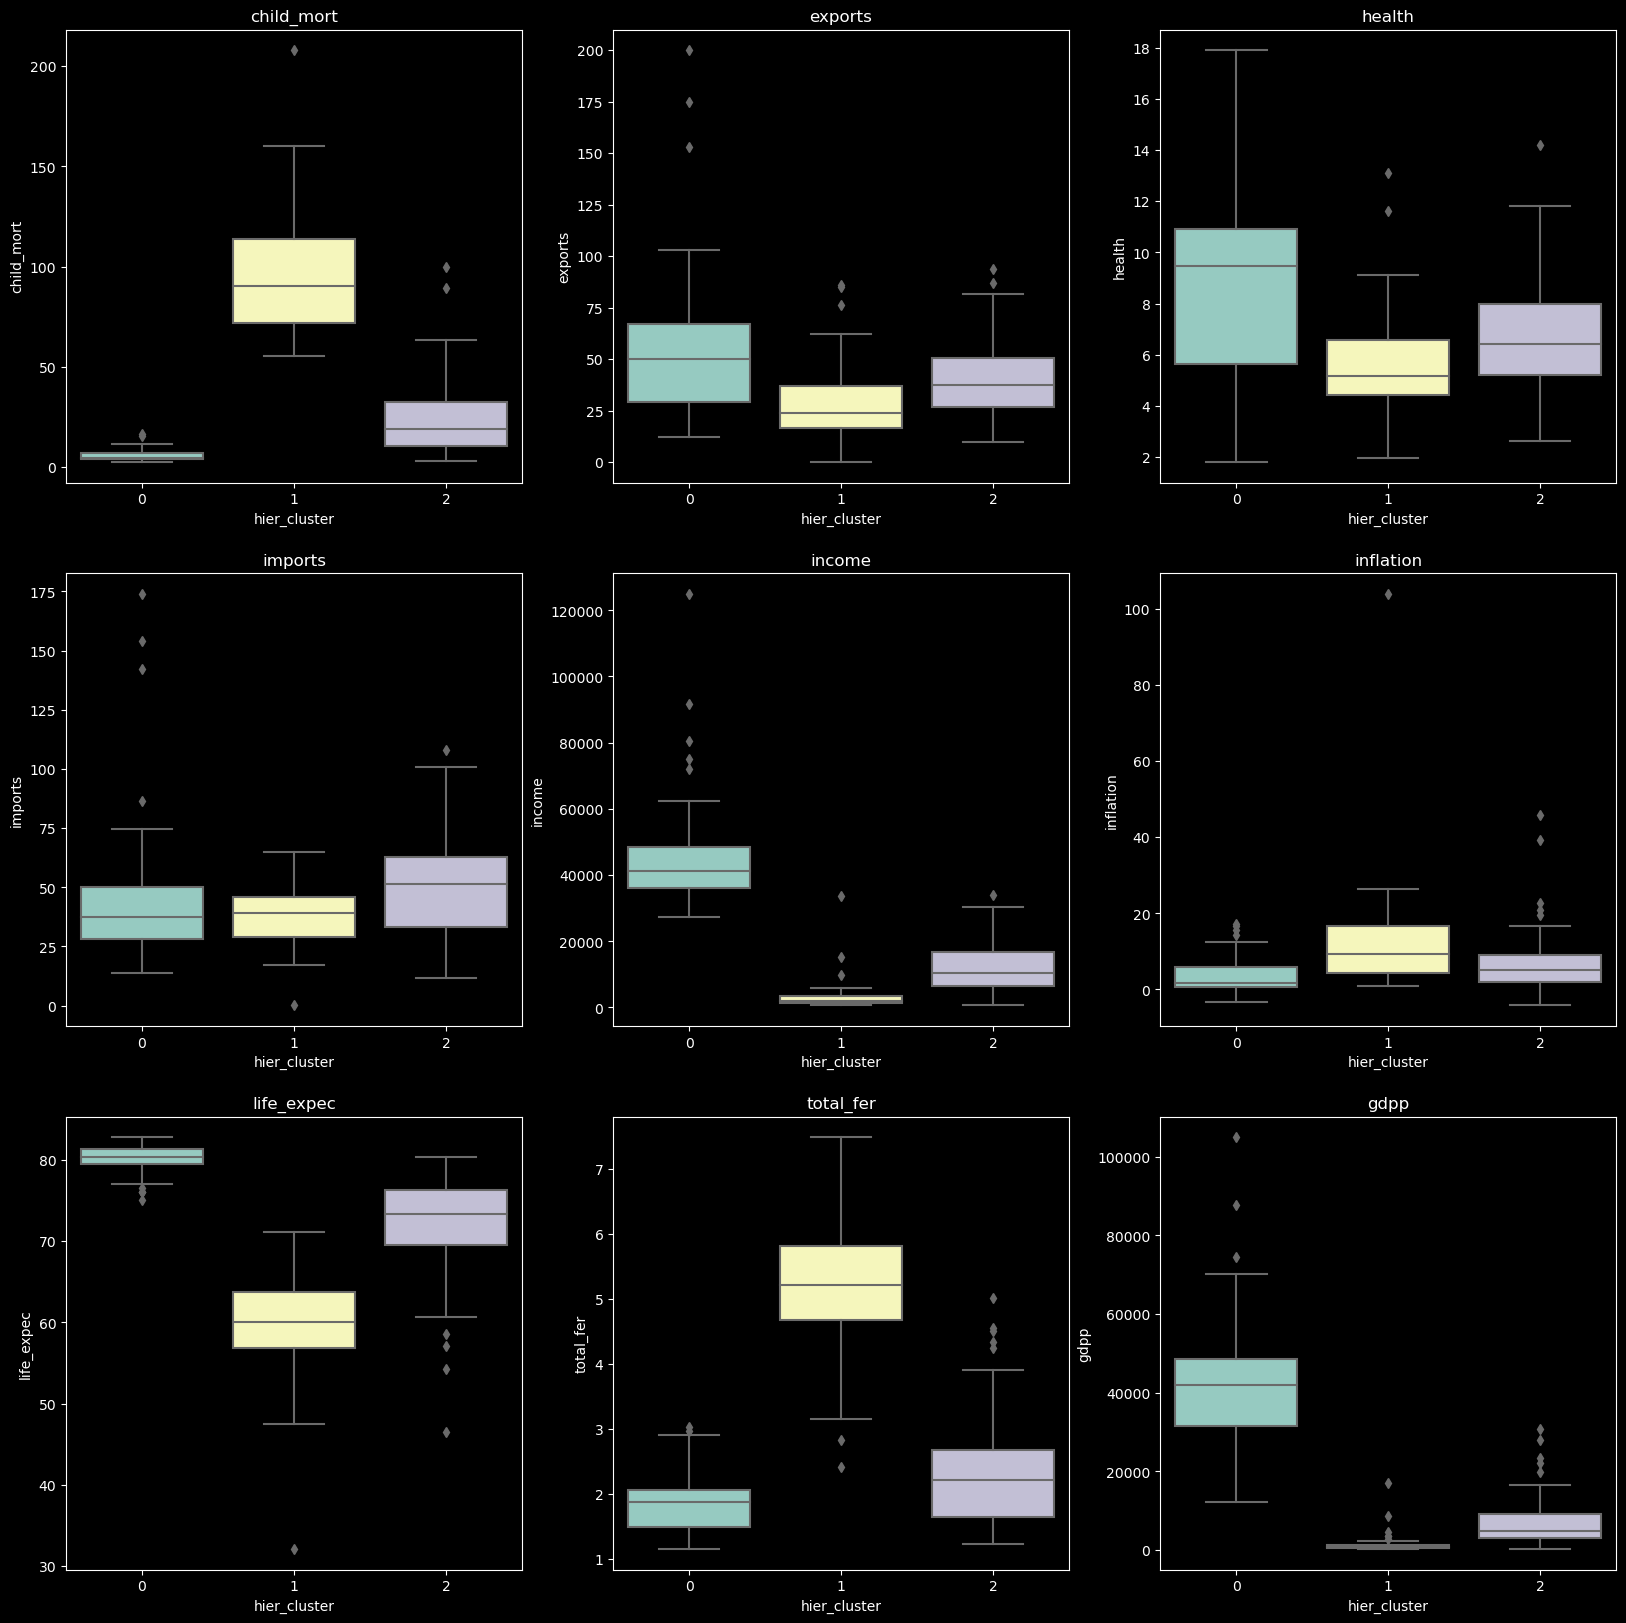

In [110]:
plt.figure(figsize=(20,20))

cols = ['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']

for i in range(len(cols)):
    plt.subplot( 3, 3, i + 1)
    sns.boxplot( x=df_result['hier_cluster'], y=df_result[ cols[i] ] )
    plt.title( cols[i])

A partir das distribuições das features para cada cluster, pode-se classificar os 3 grupos de países em:
- **Cluster 0**: Desenvolvido
- **Cluster 1**: Subdesenvolvidos
- **Cluster 2**: Emergente

In [111]:
df_result['hier_class']=""
df_result.loc[ df_result['hier_cluster'] == 0, 'hier_class'] = 'Desenvolvido'
df_result.loc[ df_result['hier_cluster'] == 1, 'hier_class'] = 'Subdesenvolvido'
df_result.loc[ df_result['hier_cluster'] == 2, 'hier_class'] = 'Emergente'

# 6. Results

## 6.1 K-Means vs Hierarchical Clustering

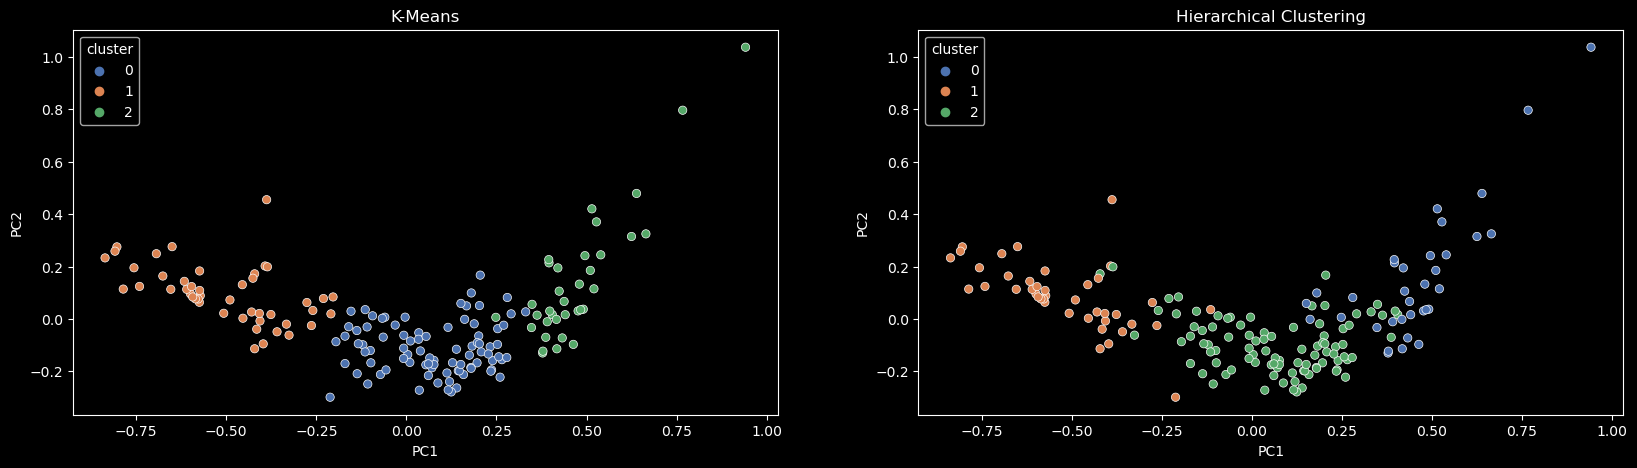

In [112]:
plt.subplot(1,2,1)
plot_cluster_points( df4, model_kmeans.labels_, title='K-Means')

plt.subplot(1,2,2)
plot_cluster_points( df4, model_agg.labels_, title='Hierarchical Clustering')

In [113]:

fig = px.choropleth(df_result[['country','kmeans_class']],
                    locationmode = 'country names',
                    locations = 'country',
                    color = df_result['kmeans_class'],
                    color_discrete_map={'Desenvolvido':'blue', 'Emergente':'goldenrod', 'Subdesenvolvido':'red'},
                    title = 'KMeans Clustered Countries'                 
)

fig.update_geos(fitbounds = "locations", 
                visible = False
                )

fig.update_layout(mapbox_style="carto-positron",
                  height=600, 
                  width = 1000,
                  margin={"r":0,"t":0,"l":0,"b":0},
                  title_x=0.02,
                  title_y=0.98,
                  legend_title_text = 'Country',
                  geo=dict(
                        showframe=False,
                        showcoastlines=True,
                        projection_type='equirectangular',
                    ),
                 )

fig.show()


fig = px.choropleth(df_result[['country','hier_class']],
                    locationmode = 'country names',
                    locations = 'country',
                    color = df_result['hier_class'],
                    color_discrete_map={'Desenvolvido':'blue', 'Emergente':'goldenrod', 'Subdesenvolvido':'red'},
                    title = 'Hierarchical Clustered Countries'                 
)

fig.update_geos(fitbounds = "locations", 
                visible = False
                )

fig.update_layout(mapbox_style="carto-positron",
                  height=600, 
                  width = 1000,
                  margin={"r":0,"t":0,"l":0,"b":0},
                  title_x=0.02,
                  title_y=0.98,
                  legend_title_text = 'Country',
                  geo=dict(
                        showframe=False,
                        showcoastlines=True,
                        projection_type='equirectangular',
                    ),
                 )

fig.show()

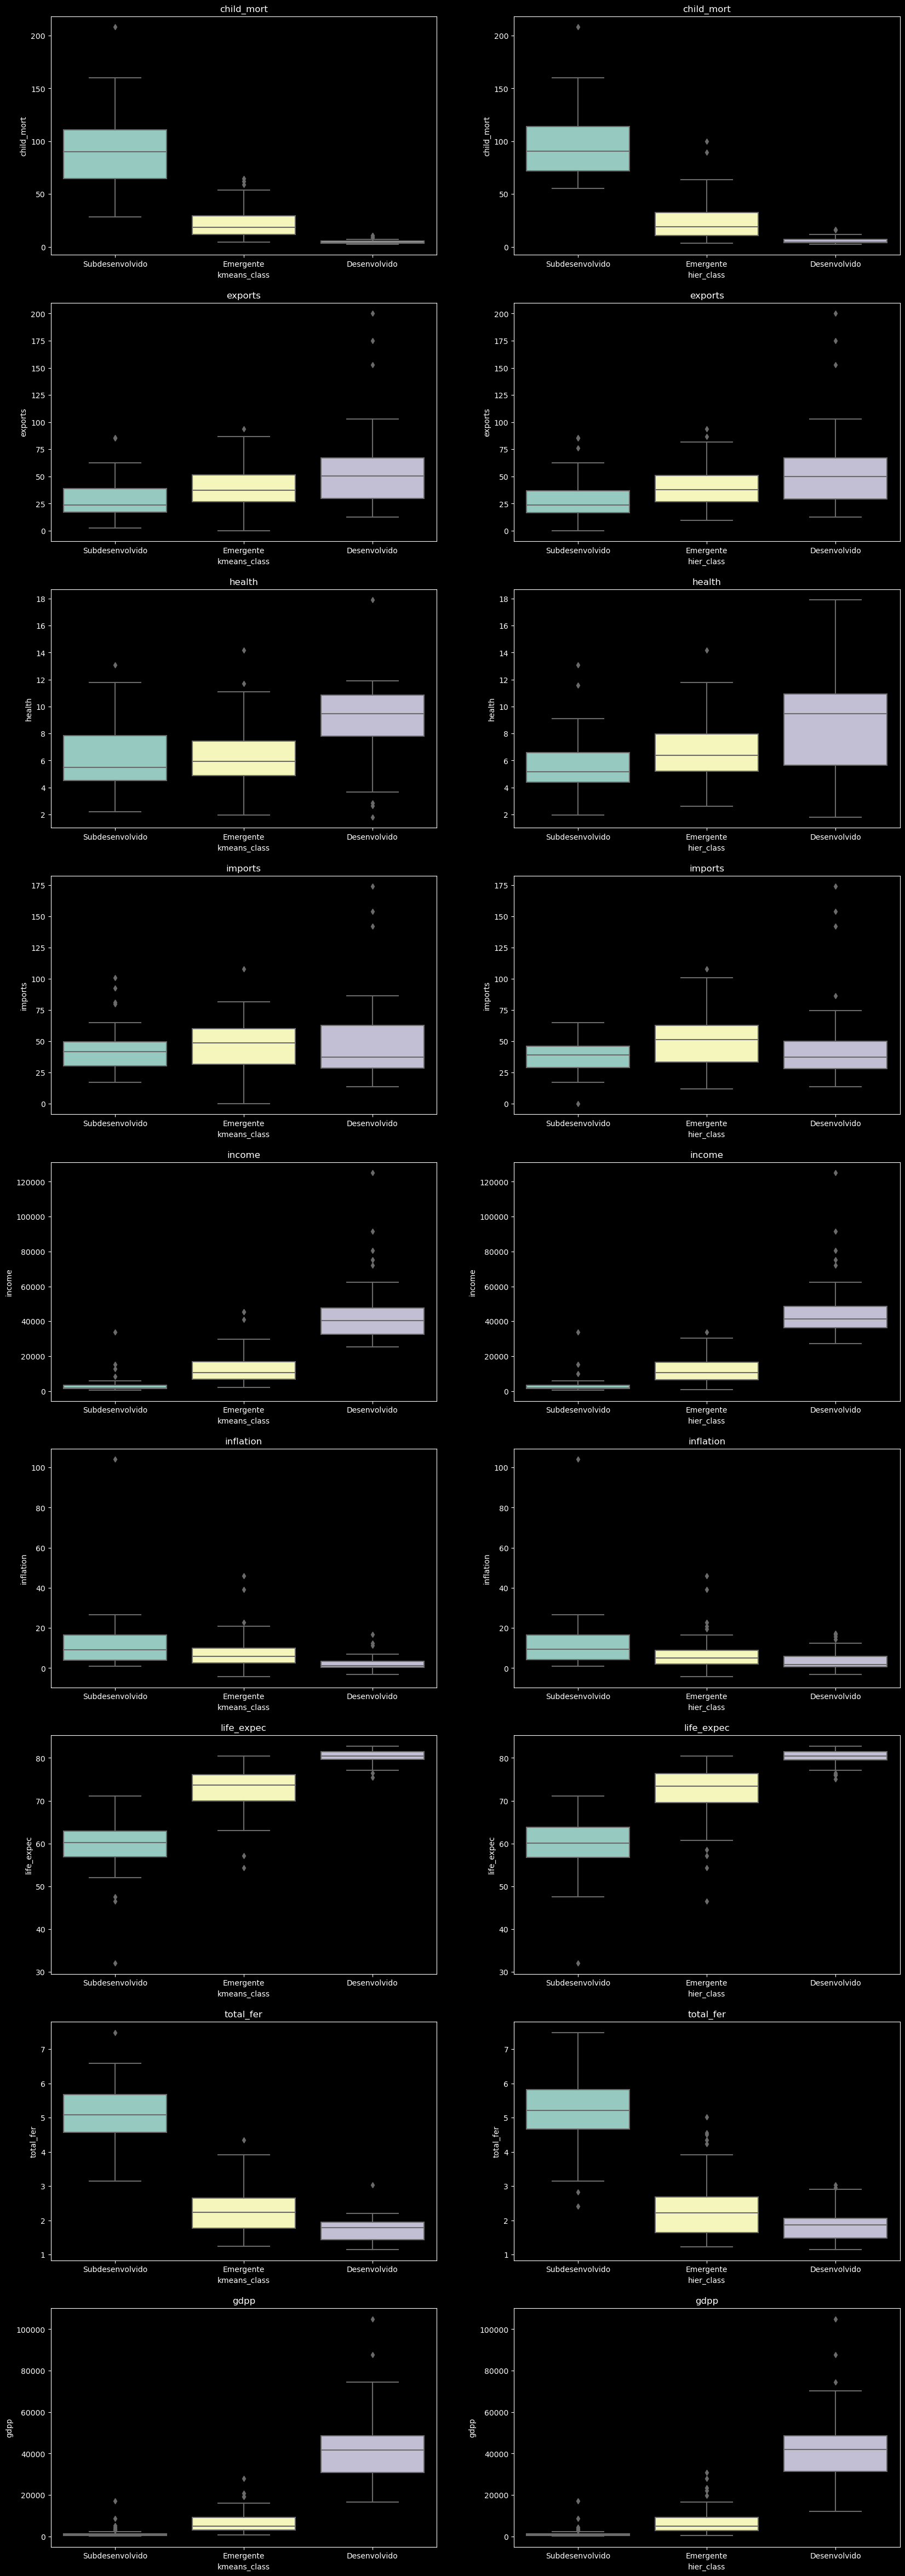

In [114]:
plt.figure(figsize=(20,60))

cols = ['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']

i=0
for k in range(len(cols)):
    plt.subplot( 9, 2, i + 1)
    sns.boxplot( x=df_result['kmeans_class'], y=df_result[ cols[k] ] )
    plt.title( cols[k])
    plt.subplot( 9, 2, i + 2)
    sns.boxplot( x=df_result['hier_class'], y=df_result[ cols[k] ])
    plt.title( cols[k])
    i = i + 2

In [115]:
# K-Means: pontos médios de cada cluster 

df_cluster = df_result.copy()
df_cluster['country'] = df_cluster.index

df_cluster = df_cluster[['country', 'kmeans_cluster']].groupby( 'kmeans_cluster' ).count().reset_index()

df_avg = df_result[['child_mort', 'exports', 'health', 'imports', 'income', 'inflation',
                        'life_expec', 'total_fer', 'gdpp', 'kmeans_cluster', 'kmeans_class']].groupby( 'kmeans_class' ).mean().reset_index()

df_cluster = pd.merge( df_cluster, df_avg, how='inner', on='kmeans_cluster' )

df_cluster.sort_values(by=['kmeans_class'])

,kmeans_cluster,country,kmeans_class,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
2,2,35,Desenvolvido,4.897143,58.431429,8.917429,51.508571,45802.857143,2.535000,80.245714,1.741143,43117.142857
0,0,86,Emergente,22.425581,40.382430,6.215581,46.932162,12770.813953,7.609023,72.582558,2.293256,6719.790698
1,1,46,Subdesenvolvido,93.284783,29.287174,6.338478,43.297826,3516.804348,12.097065,59.393478,5.090217,1695.913043


In [116]:
# Clusterização Hierárquica: pontos médios de cada cluster 

df_cluster = df_result.copy()
df_cluster['country'] = df_cluster.index

df_cluster = df_cluster[['country', 'hier_cluster']].groupby( 'hier_cluster' ).count().reset_index()

df_avg = df_result[['child_mort', 'exports', 'health', 'imports', 'income', 'inflation',
                        'life_expec', 'total_fer', 'gdpp', 'hier_cluster', 'hier_class']].groupby( 'hier_class' ).mean().reset_index()

df_cluster = pd.merge( df_cluster, df_avg, how='inner', on='hier_cluster' )

df_cluster.sort_values(by=['hier_class'])

,hier_cluster,country,hier_class,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,0,34,Desenvolvido,5.961765,58.508824,8.501176,48.902941,47588.235294,4.115500,79.982353,1.888529,43170.588235
2,2,92,Emergente,23.991304,39.919348,6.756304,50.121739,11943.804348,6.897217,71.920652,2.367174,6829.391304
1,1,41,Subdesenvolvido,97.102439,29.349244,5.551220,37.969900,3569.097561,12.807195,59.675610,5.129756,1680.731707


Conclusões:
- De acordo com o K-Measn existem 46 países que mais precisam de ajuda. E de acordo com a Clusterização Hierárquica, existem 41 países que mais precisam de ajuda.
- O algoritmo do K-Means identificou mais países subdesenvolvidos e menos países Emergentes do que a Clusterização Hierárquica. Mas a quantidade de países desenvovidos encontrado por cada algoritmo foi bem similar, apesar de não serem exatamente os mesmos países.
- Analisando os primeiros gráficos dessa seção, para o algoritmo da Clusterização Hierárquica parece exister uma zona de confusão entre os países emergentes e subdesenvolvidos, e uma zona de confusão entres os países emergentes e desenvolvidos. O algoritmo do K-Means conseguiu encontrar uma separação melhor entre esses grupos.
- Comparando os clusters de ambos algoritmos, as features que apresentaram maior divergência nas distribuições, foram: health e imports:
  - Health: a distribuição dessa feature apresentou diferença principalmente para os clusters dos países desenvolvidos e subdesenvolvidos
  - Imports: a distribuição dessa feature apresentou diferença principalmente para os clusters dos países desenvolvidos

